In [1]:
!pip install torchtext==0.4.0
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 222.6 kB/s eta 0:00:58
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.1/12.8 MB 491.5 kB/s eta 0:00:26
     - -------------------------------------- 0.5/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 4.4 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.8 MB 5.4 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 6.4 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.8 MB 6.8 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 7.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.2/12.8 MB 8.1 MB/s eta 0:00:02
     ----------- ---------------------------- 3.6/12.8 MB 8.2 M

In [2]:
pip install "numpy<2"

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torchtext import data, datasets
import random

SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# TEXT field for tokenization
TEXT = data.Field(tokenize='spacy', 
                  tokenizer_language='en_core_web_sm', 
                  include_lengths=True)

# LABEL field for the multi-class classification labels 
LABEL = data.LabelField()

In [4]:
# Load and split dataaset into the predefined training and test sets 
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

# Split training data into train and validation sets 
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

# Check data
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

# Print example
print(vars(train_data.examples[0]))

Number of training examples: 4362
Number of validation examples: 1090
Number of testing examples: 500
{'text': ['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?'], 'label': 'ENTY'}


Part A 

In [5]:
# Choose pre_trained_vectors
PRE_TRAINED_VECTORS = "glove.6B.300d" 

# Build vocabulary
TEXT.build_vocab(train_data, 
                 vectors=PRE_TRAINED_VECTORS, 
                 unk_init=torch.Tensor.normal_) 
#Q1(c) unk_init=torch.Tensor.normal_ initialized all words not found in GloVe (our OOV words) with random numbers from a normal distribution

LABEL.build_vocab(train_data)

Q1(a)

In [6]:
# Vocabulary size
vocab_size = len(TEXT.vocab)
print(f"The size of the vocabulary from the training data is: {vocab_size}")

The size of the vocabulary from the training data is: 8093


Q1(b)

In [7]:
# Q1(b)

# Load the pre-trained vector dictionary manually to check for existence
from torchtext.vocab import GloVe
glove_vectors = GloVe(name='6B', dim=300)

# Count total OOV words
oov_words = []
for word in TEXT.vocab.itos:
    if word not in glove_vectors.stoi: 
        if word not in ['<unk>', '<pad>']:
            oov_words.append(word)

print(f"Total number of OOV words: {len(oov_words)}")

# Number of unique OOV words per topic category
import collections
oov_by_topic = collections.defaultdict(set)
for example in train_data.examples:
    topic = example.label
    for word in example.text:
        if word in oov_words:
            oov_by_topic[topic].add(word)

print("\nNumber of OOV words per topic category:")
for topic, words in oov_by_topic.items():
    print(f"{topic}: {len(words)}")

Total number of OOV words: 3161

Number of OOV words per topic category:
ENTY: 896
LOC: 735
HUM: 1331
NUM: 641
DESC: 621
ABBR: 60


Q1(d)

Text(0, 0.5, 't-SNE Component 2')

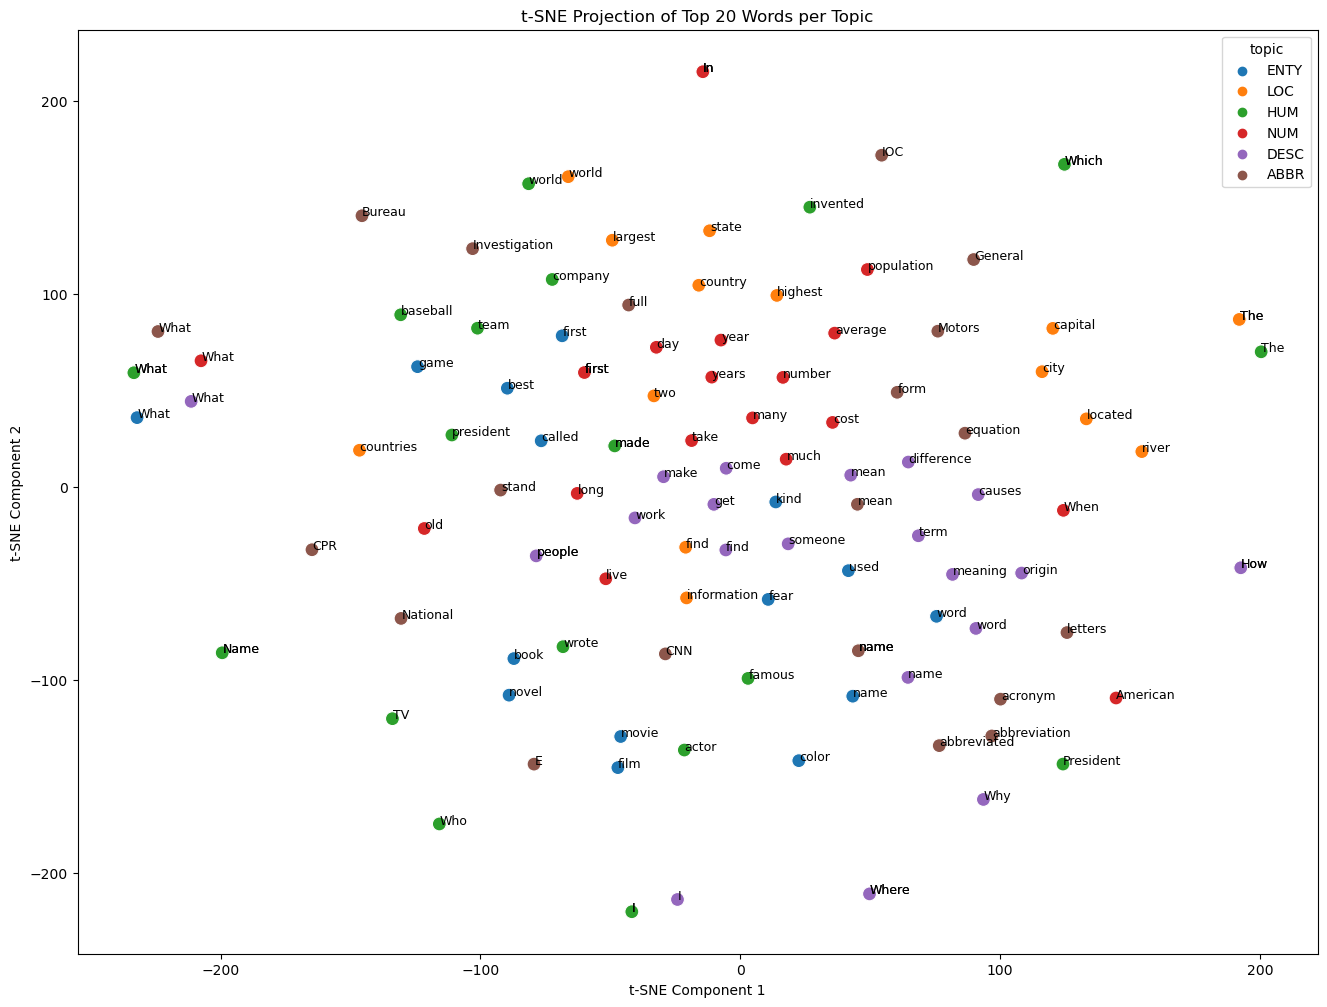

In [8]:
import nltk
from nltk.corpus import stopwords
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np  

stop_words = set(stopwords.words('english'))

topic_word_counts = collections.defaultdict(collections.Counter)
for ex in train_data.examples:
    topic = ex.label
    for word in ex.text:
        if word not in stop_words and word.isalpha(): # Check if alphabetic
            topic_word_counts[topic][word] += 1

top_words_data = []
for topic, counter in topic_word_counts.items():
    for word, freq in counter.most_common(20):
        if word in TEXT.vocab.stoi: # Ensure word is in our vocab
            vector = TEXT.vocab.vectors[TEXT.vocab.stoi[word]].numpy()
            top_words_data.append({'word': word, 'topic': topic, 'vector': vector})

df = pd.DataFrame(top_words_data)


vectors_for_tsne = np.array(list(df['vector']))

vectors_2d = TSNE(n_components=2, random_state=SEED).fit_transform(vectors_for_tsne)

df['x'] = vectors_2d[:, 0]
df['y'] = vectors_2d[:, 1]

plt.figure(figsize=(16, 12))
sns.scatterplot(data=df, x='x', y='y', hue='topic', legend='full', s=100) # s=size

# Add labels
for i, row in df.iterrows():
    plt.text(row['x'] + 0.1, row['y'], row['word'], fontsize=9)

plt.title('t-SNE Projection of Top 20 Words per Topic')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')